In [35]:
import numpy as np
import pandas as pd
from tqdm import tqdm
# import pybgen
from helpers import EnsembleResults
from ICD10_codes_dict import ICD10_CODES

In [17]:
class Repos:
    
    import os    
    
    GWAS = f"{os.environ['HOME']}/01_repos/GWAS_pipeline/"
    CARDIAC = f"{os.environ['HOME']}/01_repos/CardiacCOMA/"
    CARDIAC_MOTION = f"{os.environ['HOME']}/01_repos/CardiacMotionRL"
    CARDIAC_GWAS = f"{os.environ['HOME']}/01_repos/CardiacGWAS/"
    CARDIAC_MOTION_GWAS = f"{os.environ['HOME']}/01_repos/CardiacMotionGWAS/"
    UKBB_HELPERS = f"{os.environ['HOME']}/01_repos/UKBB_helpers"
    

In [3]:
dosages_df = pd.read_csv(f"{Repos.CARDIAC_MOTION_GWAS}/data/dosages.csv").set_index("ID")

___

Load IDs for different diseases

In [25]:
import os
import fileinput

# Define the root directory you want to start from
root_directory = f"{Repos.UKBB_HELPERS}/data/subject_ids/icd_10"

# Use list comprehension to count lines for each file in each directory
line_counts = {
    os.path.join(root, file): sum(1 for _ in fileinput.input(os.path.join(root, file)))
    for root, _, files in os.walk(root_directory)
    for file in files
}

line_counts = { k:v for k,v in line_counts.items() if v > 5000 }

In [36]:
kk = { k.split("/")[-1].replace(".txt", ""): v for k, v in line_counts.items() }
kk = { ICD10_CODES[k]: v for k, v in kk.items() }

ids_for_disease = { k.split("/")[-1][:-4]: set([ id.strip() for id in open(k).readlines()]) for k in line_counts }

In [54]:
all_diseased_ids = {element for value in ids_for_disease.values() for element in value}
healthy = pd.Series(dosages_df.index).apply(lambda id: int(str(id) not in all_diseased_ids))
healthy.index = dosages_df.index

In [ ]:
healthy_ids = healthy[healthy == 1].index

In [169]:
import sklearn
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import AdaBoostClassifierRandomForestClassifier
from sklearn.model_selection import train_test_split
import ipywidgets as widgets

In [117]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.datasets import make_classification

In [294]:
disease_w = widgets.Select(options={v:k for k,v in ICD10_CODES.items() if k in ids_for_disease})
disease_w

Select(options={'Pulmonary embolism without acute cor pulmonale': 'I269', 'Congestive heart failure': 'I500', …

In [769]:
disease_w.value

'I209'

In [770]:
dosage_ids = set(dosages_df.index)

In [771]:
case_ids = ids_for_disease[disease_w.value]
control_ids = healthy_ids[:4*len(case_ids)]

case_ids = [int(x) for x in case_ids]
case_ids = [x for x in case_ids if x in dosage_ids]

control_ids = [int(x) for x in control_ids]
control_ids = [x for x in control_ids if x in dosage_ids]

In [772]:
covariates_df = pd.read_csv("/home/user/01_repos/UKBB_helpers/data/transforms/covariates.tsv", sep="\t")
covariates_df = covariates_df.set_index("FID").drop("IID", axis=1)
intersec_ids = set(case_ids + control_ids).intersection(covariates_df.index)
covariates_df = covariates_df.loc[intersec_ids]

/tmp/ipykernel_243675/2087379438.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  covariates_df = covariates_df.loc[intersec_ids]


In [773]:
dosages = dosages_df.loc[case_ids+control_ids]
labels = [1]*len(case_ids) + [0]*len(control_ids)
dosages = dosages.fillna(dosages.mean())

In [774]:
filter_bool = dosages.reset_index().ID.apply(lambda id: id in intersec_ids)
filter_bool.index = dosages.index
dosages = dosages.loc[filter_bool]
labels = [l for i, l in enumerate(labels) if filter_bool.iloc[i]]

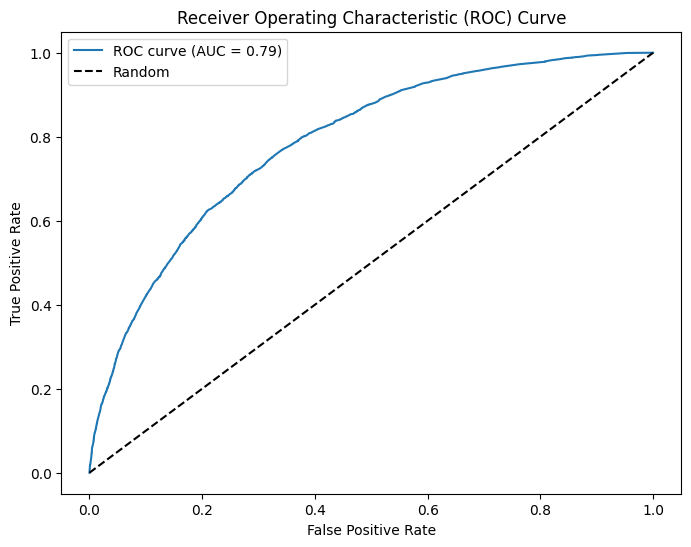

In [779]:
# X, y = pd.concat([dosages, covariates_df], axis=1), labels
# X, y = pd.concat([dosages, covariates_df.iloc[:,[0,3,5]]], axis=1), labels
X, y = covariates_df.loc[dosages.index], labels
X_train, X_test, y_train, y_test = train_test_split(X, y)
# model = LogisticRegression(penalty='l2', max_iter=1000) 
model = RandomForestClassifier(n_estimators = 20, max_depth = 5, max_features = 50, bootstrap = True, random_state = 18)
model.fit(X_train, y_train)
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [778]:
model.feature_importances_

array([0.14150416, 0.00669191, 0.07109796, 0.20150051, 0.04779508,
       0.53141038])